In [1]:
import urllib.request 
import json
import os
import re
import sqlite3

In [43]:
conn = sqlite3.connect('postupashki.db')
c = conn.cursor()

In [46]:
from datetime import datetime

c.execute("CREATE TABLE IF NOT EXISTS posts(Post_id integer, Post text, Month integer, Signer_id boolean)")

offset = 100
posts_id = {}
while offset<215:
    req = urllib.request.Request('https://api.vk.com/method/wall.get?owner_id=-76552532&offset=%d&count=1&v=5.92&access_token=15447ea615447ea615447ea6d2152e41051154415447ea64980188fc12a2caec6bd1eb8' % offset)
    response = urllib.request.urlopen(req) 
    result = response.read().decode('utf-8')
    data = json.loads(result) 
    post_id = data['response']['items'][0]['id']
    date = data['response']['items'][0]['date']
    unixtime = data['response']['items'][0]['date'] 
    utc = datetime.fromtimestamp(unixtime) 
    reg_month = re.search(r'-(\d+)-', str(utc))
    month = reg_month.group(1)
    if 'signer_id' in data['response']['items'][0].keys():
        signer = 1
    else:
        signer = 0
    c.execute('INSERT INTO posts VALUES (?, ?, ?, ?)', (post_id, data['response']['items'][0]['text'], month, signer))
    conn.commit()
        
    posts_id[post_id] = data['response']['items'][0]['comments']['count']
    dirname = '.\corpus\plain\post%d' % post_id
    os.makedirs(dirname)
    filename = 'post%d.txt' % post_id
    filepath = os.path.join(dirname,filename)
    with open (filepath, 'w', encoding='utf-8') as f:
        f.write(data['response']['items'][0]['text'])
    offset += 1

In [44]:
c.execute("CREATE TABLE IF NOT EXISTS posts_comments(Post id integer, Comment id integer)")
c.execute("CREATE TABLE IF NOT EXISTS comments(Commentid integer, Comment text, Author id integer, City text, Pages integer )")
          
for id in posts_id.keys():
    offset = 0
    while offset<posts_id[id]:
        req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id=-76552532&post_id=%d&offset=%d&count=1&v=5.92&access_token=15447ea615447ea615447ea6d2152e41051154415447ea64980188fc12a2caec6bd1eb8' % (id,offset))
        response = urllib.request.urlopen(req) 
        result = response.read().decode('utf-8')
        data = json.loads(result)
        if len(data['response']['items'])>0:
            if 'deleted' not in data['response']['items'][0].keys():
                comment_id = data['response']['items'][0]['id']
                c.execute('INSERT INTO posts_comments VALUES (?, ?)', (id, comment_id))
                author = data['response']['items'][0]['from_id']
                req = urllib.request.Request('https://api.vk.com/method/users.get?user_id=%s&v=5.92&access_token=15447ea615447ea615447ea6d2152e41051154415447ea64980188fc12a2caec6bd1eb8&fields=city,counters' % author)
                response = urllib.request.urlopen(req) 
                result = response.read().decode('utf-8')
                pers_data = json.loads(result)
                if 'response' in pers_data:
                    if 'city' in (pers_data['response'][0]):
                        city = pers_data['response'][0]['city']['title']
                    else:
                        city = '-'
                    if 'counters' in (pers_data['response'][0]):
                        pages_count = pers_data['response'][0]['counters']['pages']
                    else:
                        pages_count = -1
                    c.execute('INSERT INTO comments VALUES (?, ?, ?, ?, ?)', (comment_id, data['response']['items'][0]['text'], author, city, pages_count))
                    dirname = '.\corpus\plain\post%d' % id
                    filename = 'comment%d.txt' % comment_id
                    filepath = os.path.join(dirname,filename)
                    with open (filepath, 'w', encoding='utf-8') as f:
                        f.write(data['response']['items'][0]['text'])
        offset += 1
conn.commit()
conn.close()    
                                     
                                     

In [ ]:
os.mkdir('.\corpus\lemmatized')
for dir in os.listdir('.\corpus\plain'):
    lemmatized_dir = os.path.join(r'C:\Users\Maria\Documents\hw6\corpus\lemmatized', dir)
    justtext_dir = os.path.join(r'C:\Users\Maria\Documents\hw6\corpus\plain', dir)
    os.mkdir(lemmatized_dir)
    for file in os.listdir(justtext_dir):
        justtext_filepath = os.path.join(justtext_dir, file)
        lemmatized_filepath = os.path.join(lemmatized_dir, file)
        os.system(r'C:\Users\Maria\Documents\mystem.exe  -c -d -l  '+ justtext_filepath + ' ' + lemmatized_filepath )


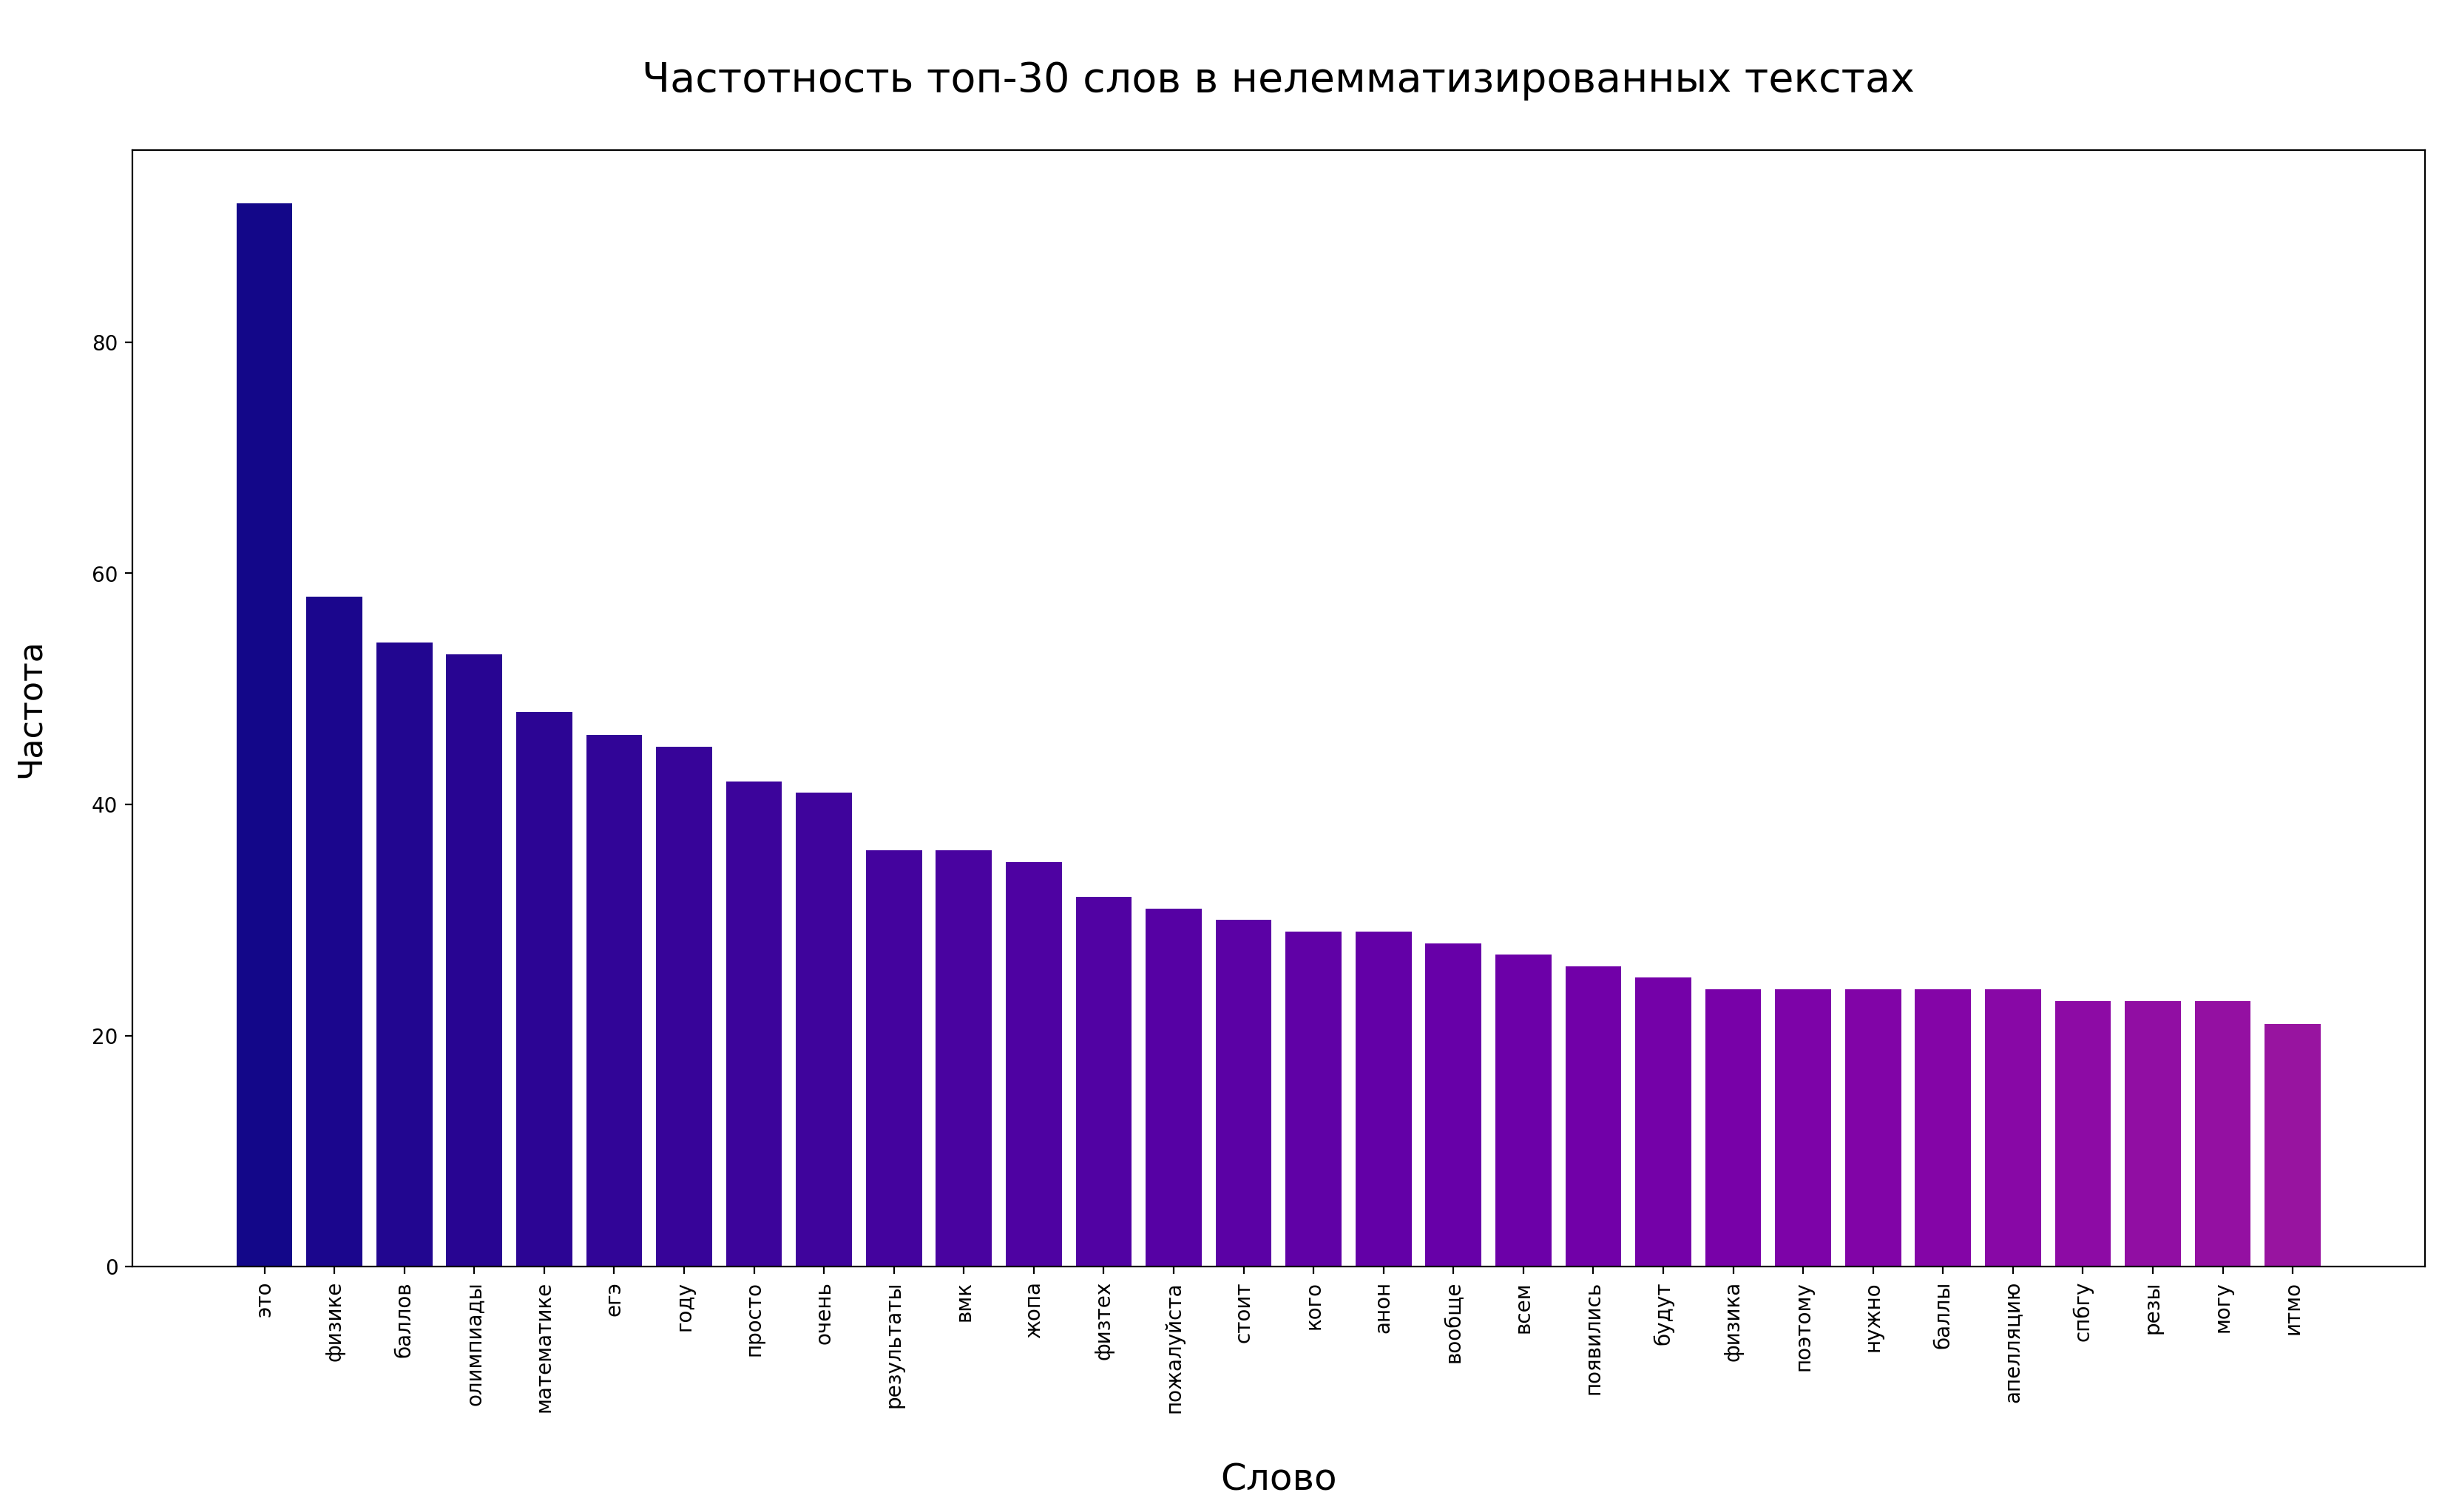

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from nltk.corpus import stopwords


words_in_posts = []
new_counter = {}
for dir in os.listdir('.\corpus\plain'):
    dirpath = os.path.join('.\corpus\plain', dir)
    for file in os.listdir(dirpath):
        filepath = os.path.join(dirpath, file)
        with open(filepath, encoding='utf-8') as f:
            text = f.read()
        text = text.lower()
        words_in_text = re.findall(r'(\b[а-я]+\b)', text)
        words_in_posts.extend(words_in_text)
counter = collections.Counter(words_in_posts)
for word in counter.keys():
    if word not in stopwords.words('russian'):
        new_counter[word] = counter[word]
new_counter = sorted([(value,key) for (key,value) in new_counter.items()], reverse=True)
words = []
freq = []
for i in new_counter[:30]:
    words.append(i[1])
    freq.append(i[0])
x = range(len(freq))
colors = sns.color_palette('plasma', min(freq)) 

plt.figure(figsize=(20, 10), dpi=200)
plt.bar(words, freq, color=colors)
plt.title('\nЧастотность топ-30 слов в нелемматизированных текстах\n',  fontsize=20)
plt.ylabel('Частота\n',  fontsize=16)
plt.xlabel('\nСлово',  fontsize=18)
plt.xticks(x, words, rotation=90)
plt.show()
    
    

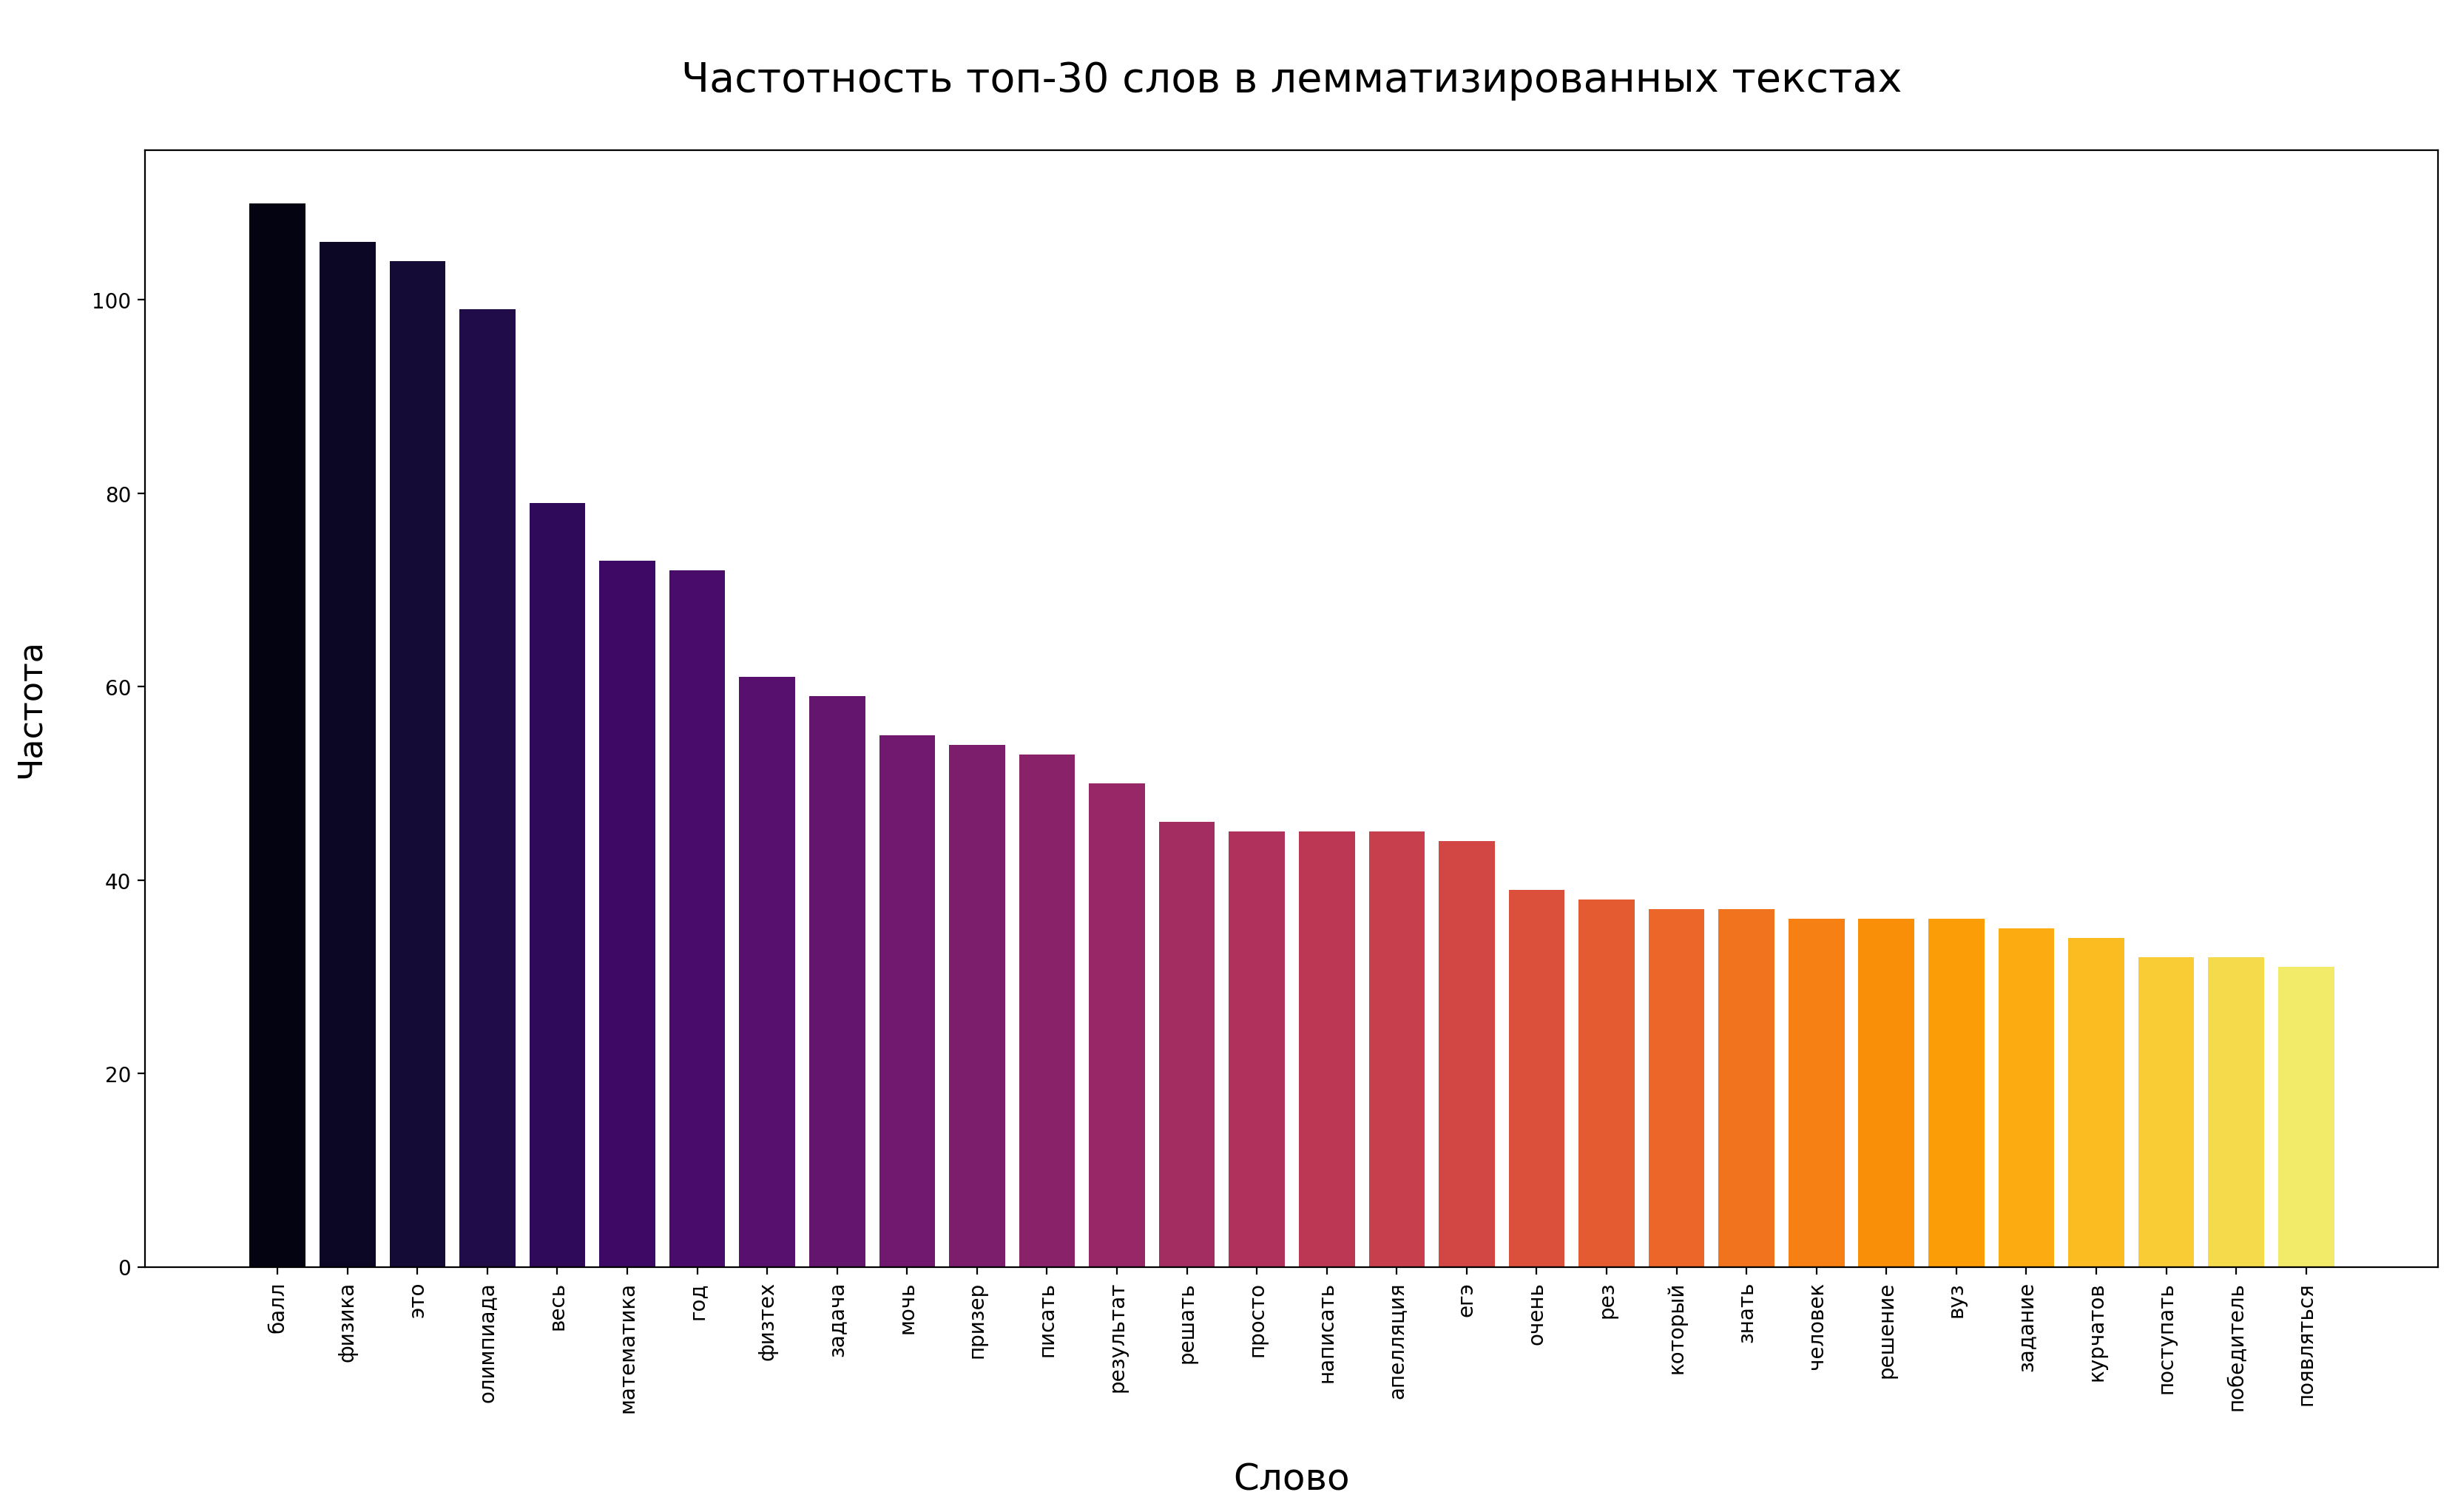

In [22]:
words_in_lem_posts = []
new_counter = {}
for dir in os.listdir('.\corpus\lemmatized'):
    dirpath = os.path.join('.\corpus\lemmatized', dir)
    for file in os.listdir(dirpath):
        filepath = os.path.join(dirpath, file)
        with open(filepath, encoding='utf-8') as f:
            lemmas = f.read()
        words_in_lemmas = re.findall(r'[а-я]+', lemmas)
        words_in_lem_posts.extend(words_in_lemmas)
counter = collections.Counter(words_in_lem_posts)
for word in counter.keys():
    if word not in stopwords.words('russian'):
        new_counter[word] = counter[word]
new_counter = sorted([(value,key) for (key,value) in new_counter.items()], reverse=True)

    
words = []
freq = []
for i in new_counter[:30]:
    words.append(i[1])
    freq.append(i[0])
x = range(len(freq))
colors = sns.color_palette('inferno', min(freq)) 

plt.figure(figsize=(20, 10), dpi=200)
plt.bar(words, freq, color=colors)
plt.title('\nЧастотность топ-30 слов в лемматизированных текстах\n',  fontsize=20)
plt.ylabel('Частота\n',  fontsize=16)
plt.xlabel('\nСлово',  fontsize=18)
plt.xticks(x, words, rotation=90)
plt.show()
    

<Figure size 640x480 with 1 Axes>

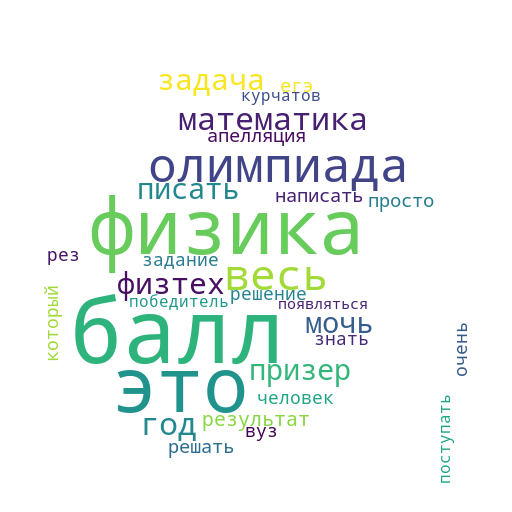

In [9]:
from PIL import Image
import numpy as np
from wordcloud import WordCloud

dict_for_wordcloud = {}
for i in new_counter[:30]:
    dict_for_wordcloud[i[1]] = i[0]
postupashki_mask = np.array(Image.open("pinguin.jpg"))

cloud = WordCloud(background_color="white", max_words=2000, mask=postupashki_mask)

cloud.generate_from_frequencies(dict_for_wordcloud)

plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


cloud.to_file("post_cloud.png")
Image.open("post_cloud.png")

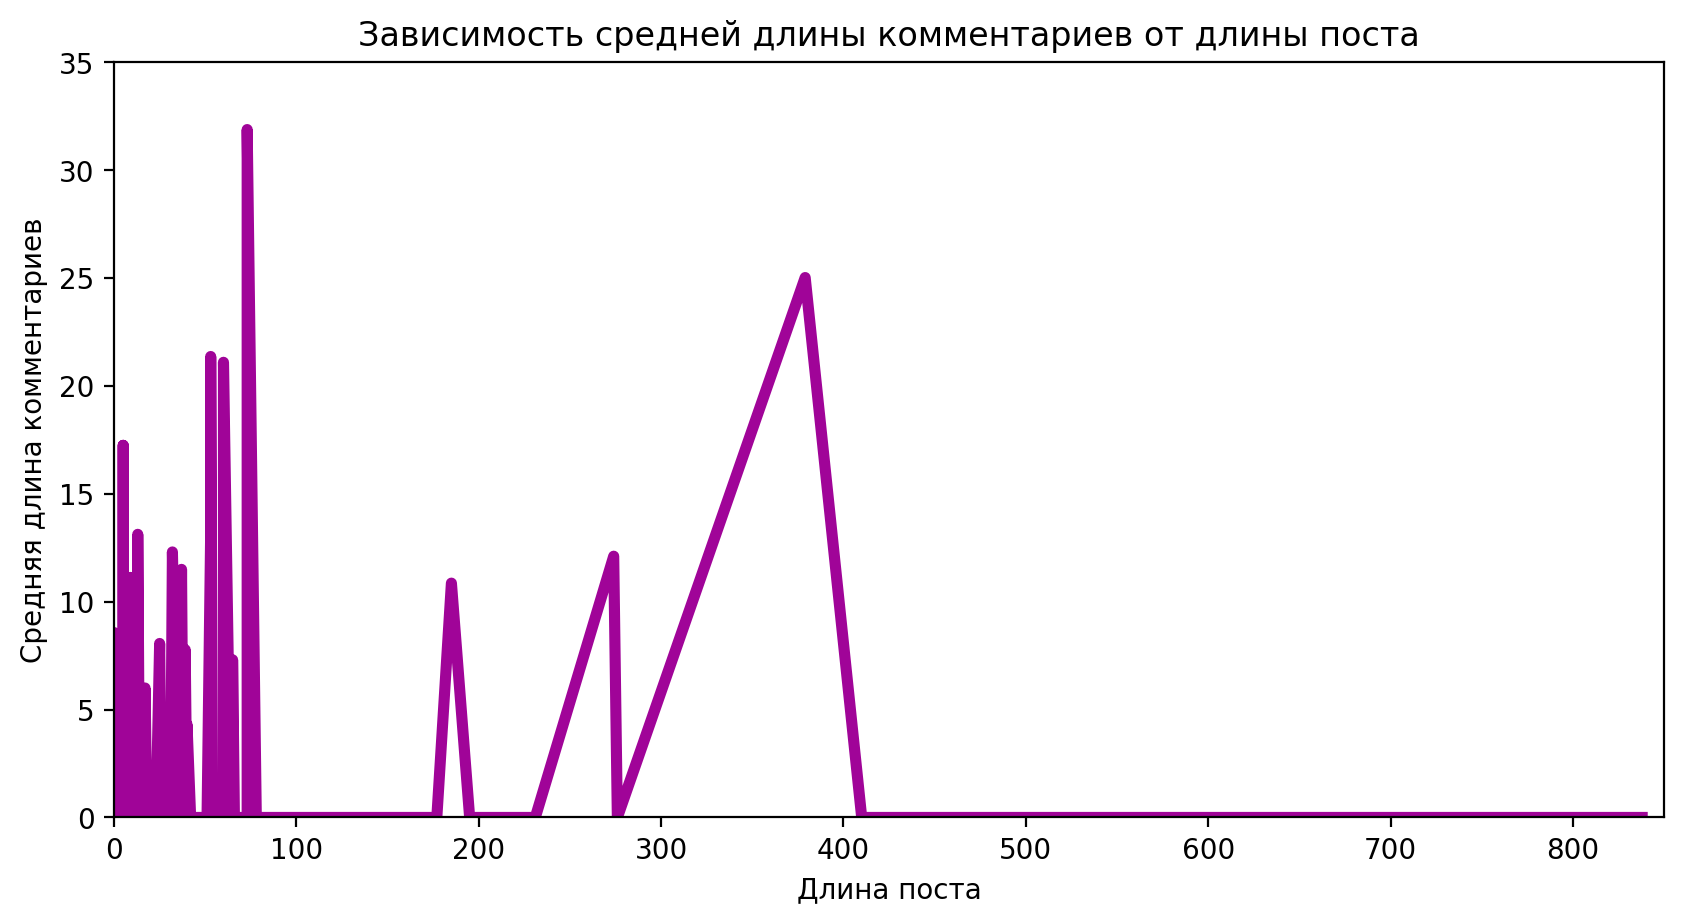

In [45]:
symbols_to_remove = ',.:;!?"-()'
post_len = []
com_mean_len = []
for dir in os.listdir('.\corpus\plain'):
    com_len = []
    dirpath = os.path.join('.\corpus\plain', dir)
    for file in os.listdir(dirpath):
        filepath = os.path.join(dirpath, file)
        with open(filepath, encoding='utf-8') as f:
            text = f.read()
        for x in symbols_to_remove:
            text = text.replace(x,'')
        if file[:4] == 'post':
            post_len.append(len(text.split()))
        if file[:7] == 'comment':
            com_len.append(len(text.split()))
    if com_len == []:
        com_mean_len.append(0)
    else:
        a = np.array(com_len)
        com_mean_len.append(a.mean())
        
        
indices = sorted(range(len(post_len)), key=lambda i: post_len[i])
post_len = [post_len[i] for i in indices]
com_mean_len = [com_mean_len[i] for i in indices]

plt.figure(figsize=(10, 5), dpi=200)
plt.plot(post_len, com_mean_len, c='#a00498', lw='4')
plt.title('Зависимость средней длины комментариев от длины поста')
plt.xlabel('Длина поста')
plt.ylabel('Средняя длина комментариев')
plt.xlim(0,850)
plt.ylim(0,35)
plt.show()